# Country Processing for Smoke Mortality Analysis

This notebook processes country-level data to calculate death rates by geographic location. It maps death rates to a global grid that can be used in smoke mortality calculations.

## Data Requirements

This notebook requires the following data files in the `./data/` directory:
- `ne_110m_admin_0_countries.shp`: Natural Earth shapefile with country boundaries
- `death_rate.xlsx`: Excel file containing death rates by country
- `ssp2_2050_matching.nc`: NetCDF file with population projections

The notebook will output:
- `death_rate.nc`: NetCDF file with death rates mapped to a global grid

In [9]:
import pandas as pd
from shapely.geometry import Point, Polygon
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from rapidfuzz import process
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

## Setup Data Directory

Check if the data directory exists and contains required files.

In [10]:
# Define the data directory relative to the notebook location
data_dir = './smoke_data'

# Check if data directory exists
if not os.path.exists(data_dir):
    print(f"Error: Data directory '{data_dir}' not found.")
    print("Please create a 'data' directory in the same location as this notebook and add the required data files.")
    required_files = ['ne_110m_admin_0_countries.shp', 'death_rate.xlsx', 'ssp2_2050_matching.nc']
    print(f"Required files: {', '.join(required_files)}")
    # Uncomment the line below if you want the notebook to stop execution when data is missing
    # sys.exit(1)

## Helper Functions

Define functions to process geographic data and fix longitude coordinates.

In [11]:
def fix_lon(ds):
    """Adjust longitude values to ensure they are within (-180, 180) range.
    
    Parameters:
        ds (xarray.Dataset): Dataset with longitude coordinates
        
    Returns:
        xarray.Dataset: Dataset with adjusted longitude coordinates
    """
    lon_name = 'lon'  # whatever name is in the data

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

In [12]:
# Function to find the country by lat, lon and return the death rate
def get_death_rate(df, lat, lon, shapefile):
    """Find the country at a given lat/lon and return its death rate.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing country death rates
        lat (float): Latitude
        lon (float): Longitude
        shapefile (cartopy.io.shapereader.Reader): Shapefile reader with country boundaries
        
    Returns:
        float: Death rate for the country at the given coordinates, or 0 if no country found
    """
    # Create a Point object for the given lat/lon
    point = Point(lon, lat)
    
    # Iterate over the countries' geometries to find the country
    for country_record in shapefile.records():
        country_name = country_record.attributes['NAME']
        country_geom = country_record.geometry
        # If point is within the country's polygon, return the death rate
        if country_geom.contains(point):
            # Use rapidfuzz to get the closest match country name
            closest_country, score, b = process.extractOne(country_name, df['Country Name'])
            if score > 80:  # ensure reasonable match threshold
                death_rate = df.loc[df['Country Name'] == closest_country, 'Death Rate'].values[0]
                return death_rate
    return 0  # If no country found

## Load Data

Load the required data files: country shapefile, death rates, and population projections.

In [13]:
# Load the world shapefile (admin boundaries)
shapefile_path = os.path.join(data_dir, 'ne_110m_admin_0_countries.shp')
try:
    shapefile = Reader(shapefile_path)
    print(f"Successfully loaded shapefile from {shapefile_path}")
except Exception as e:
    print(f"Error loading shapefile: {e}")
    print(f"Please ensure '{shapefile_path}' exists and is a valid shapefile.")

Successfully loaded shapefile from ./smoke_data/ne_110m_admin_0_countries.shp


In [14]:
# Load death rate data
death_rate_path = os.path.join(data_dir, 'death_rate.xlsx')
try:
    death_df = pd.read_excel(death_rate_path)
    print(f"Successfully loaded death rate data from {death_rate_path}")
    # Display the first few rows to verify the data
    display(death_df.head())
except Exception as e:
    print(f"Error loading death rate data: {e}")
    print(f"Please ensure '{death_rate_path}' exists and is a valid Excel file.")

Successfully loaded death rate data from ./smoke_data/death_rate.xlsx


,Country Name,Death Rate
0,Aruba,11.084000
1,Africa Eastern and Southern,7.857561
2,Afghanistan,6.906000
3,Africa Western and Central,10.281307
4,Angola,7.863000


In [15]:
# Load population data
pop_path = os.path.join(data_dir, 'ssp2_2050_matching.nc')
try:
    pop_nc = xr.open_dataset(pop_path)
    pop_nc = fix_lon(pop_nc)
    lats = pop_nc['lat'].values
    lons = pop_nc['lon'].values
    print(f"Successfully loaded population data from {pop_path}")
    # Display dataset info
    pop_nc
except Exception as e:
    print(f"Error loading population data: {e}")
    print(f"Please ensure '{pop_path}' exists and is a valid NetCDF file.")

Successfully loaded population data from ./smoke_data/ssp2_2050_matching.nc


/var/folders/g9/z04gd5q11kv9sb76x89g7zym0000gp/T/ipykernel_25604/2969152750.py:24: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name))


## Calculate Global Death Rate Grid

Map country-level death rates to a global grid based on the population data resolution.

In [16]:
# Initialize global death rate array
global_death_rate = np.zeros_like(pop_nc['ssp2_2050'].values)
print(f"Global death rate grid shape: {global_death_rate.shape}")

Global death rate grid shape: (192, 288)


In [17]:
# Calculate death rate for each grid cell
# This may take some time to run
la = 0
for lat in lats:
    if la % 10 == 0:  # Print progress every 10 latitude steps
        print(f"Processing latitude {la}/{len(lats)}")
    lo = 0
    for lon in lons:
        global_death_rate[la, lo] = get_death_rate(death_df, lat, lon, shapefile)
        lo += 1
    la += 1

print("Completed death rate calculation for all grid cells")

Processing latitude 0/192
Processing latitude 10/192
Processing latitude 20/192
Processing latitude 30/192
Processing latitude 40/192
Processing latitude 50/192
Processing latitude 60/192
Processing latitude 70/192
Processing latitude 80/192
Processing latitude 90/192
Processing latitude 100/192
Processing latitude 110/192
Processing latitude 120/192
Processing latitude 130/192
Processing latitude 140/192
Processing latitude 150/192
Processing latitude 160/192
Processing latitude 170/192
Processing latitude 180/192
Processing latitude 190/192
Completed death rate calculation for all grid cells


## Visualize and Save Results

Create a visualization of the global death rate grid and save the results to a NetCDF file.

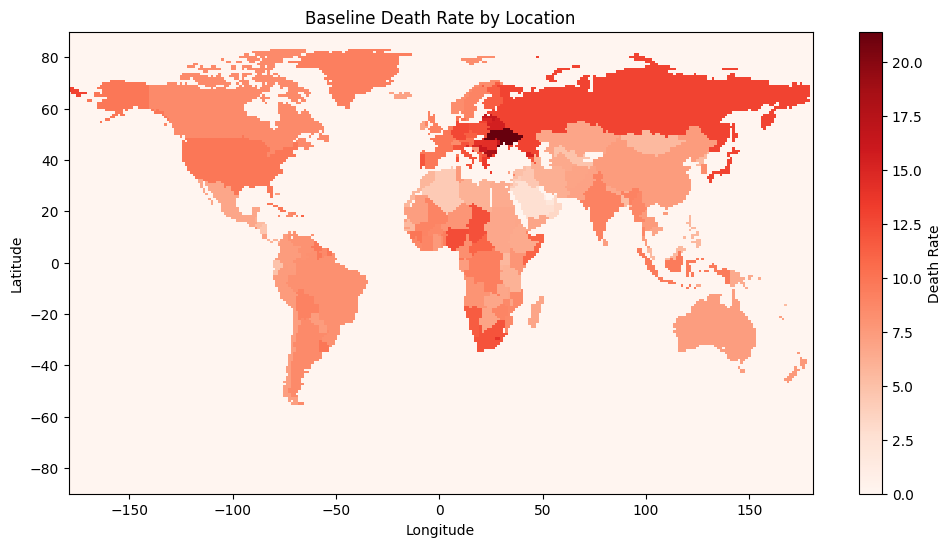

In [21]:
# Visualize the global death rate
plt.figure(figsize=(12, 6))
plt.pcolormesh(lons, lats, global_death_rate, cmap='Reds')
plt.colorbar(label='Death Rate')
plt.title('Baseline Death Rate by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [19]:
# Create a dataset with the death rate data
ds = xr.Dataset(
    {
        'death_rate': (['lat', 'lon'], global_death_rate)
    },
    coords={
        'lat': lats,
        'lon': lons
    }
)

# Save to a .nc file
output_path = os.path.join(data_dir, 'death_rate.nc')
ds.to_netcdf(output_path)
print(f"Saved death rate data to {output_path}")

Saved death rate data to ./smoke_data/death_rate.nc


In [20]:
# Verify the saved file
try:
    f = xr.open_dataset(output_path)
    print(f"Successfully verified the saved death rate file")
    # Display a sample of the values
    f['death_rate'].values
except Exception as e:
    print(f"Error verifying saved file: {e}")

Successfully verified the saved death rate file
